<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/Univariate_time_series_with_exogenous_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate Time Series Forecasting with Exogenous Variables

## Introduction
This is an example of a univariate time series with exogenous variables.

In this project, we assume that the future values of other variables, except for PM2.5, can be forecasted. Therefore, these variables are considered exogenous. PM2.5 is the target variable.



**Data Info:**


No: This is the row number or record index.

year: The year of the observation, in this example it is 2010.

month: The month of the observation, in this case, January.

day: The day of the observation, indicating the specific day of the month.

hour: The hour of the observation, using a 24-hour format (e.g., 0 represents midnight, 1 represents 1 AM).

pm2.5: The concentration of PM2.5 (fine particulate matter) in the air, possibly measured in micrograms per cubic meter (μg/m³). In this data segment, some values are missing (denoted as NA).

DEWP: Dew point temperature in degrees Celsius (°C), which indicates the temperature at which air becomes saturated and dew forms.

TEMP: The actual air temperature, measured in degrees Celsius (°C).

PRES: Atmospheric pressure, measured in hectopascals (hPa).

cbwd: Coded wind direction, shown as abbreviations like NW for northwest wind.

Iws: Cumulative wind speed, possibly measured in meters per second (m/s).

Is: Cumulative precipitation, possibly measured in millimeters (mm). In this data segment, all values are 0, indicating no precipitation.

Ir: Cumulative snowfall, possibly measured in millimeters (mm). In this data segment, all values are 0, indicating no snowfall.

## Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import pmdarima as pm
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('pollution.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [3]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


## Data Preprocessing

In [4]:
# Convert numeric columns to strings before concatenation
df['datetime'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + \
                 df['day'].astype(str) + ' ' + df['hour'].astype(str) + ':00'

df['datetime'] = pd.to_datetime(df['datetime'])



df.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)
df.set_index('datetime', inplace=True)

# Only use the last two years's data
df = df.loc[df.index > '2012-12-31 23']

df.drop(['No'], axis=1, inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,
2013-01-01 00:00:00,35.0,-10,-5.0,1018.0,NW,5.81,0,0
2013-01-01 01:00:00,31.0,-11,-7.0,1017.0,NW,9.83,0,0
2013-01-01 02:00:00,32.0,-11,-7.0,1017.0,NW,11.62,0,0
2013-01-01 03:00:00,21.0,-14,-10.0,1018.0,NW,14.75,0,0
2013-01-01 04:00:00,16.0,-15,-10.0,1018.0,cv,0.45,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2013-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm2.5   17339 non-null  float64
 1   DEWP    17520 non-null  int64  
 2   TEMP    17520 non-null  float64
 3   PRES    17520 non-null  float64
 4   cbwd    17520 non-null  object 
 5   Iws     17520 non-null  float64
 6   Is      17520 non-null  int64  
 7   Ir      17520 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.2+ MB


In [6]:
df.isnull().sum()

,0
pm2.5,181
DEWP,0
TEMP,0
PRES,0
cbwd,0
Iws,0
Is,0
Ir,0


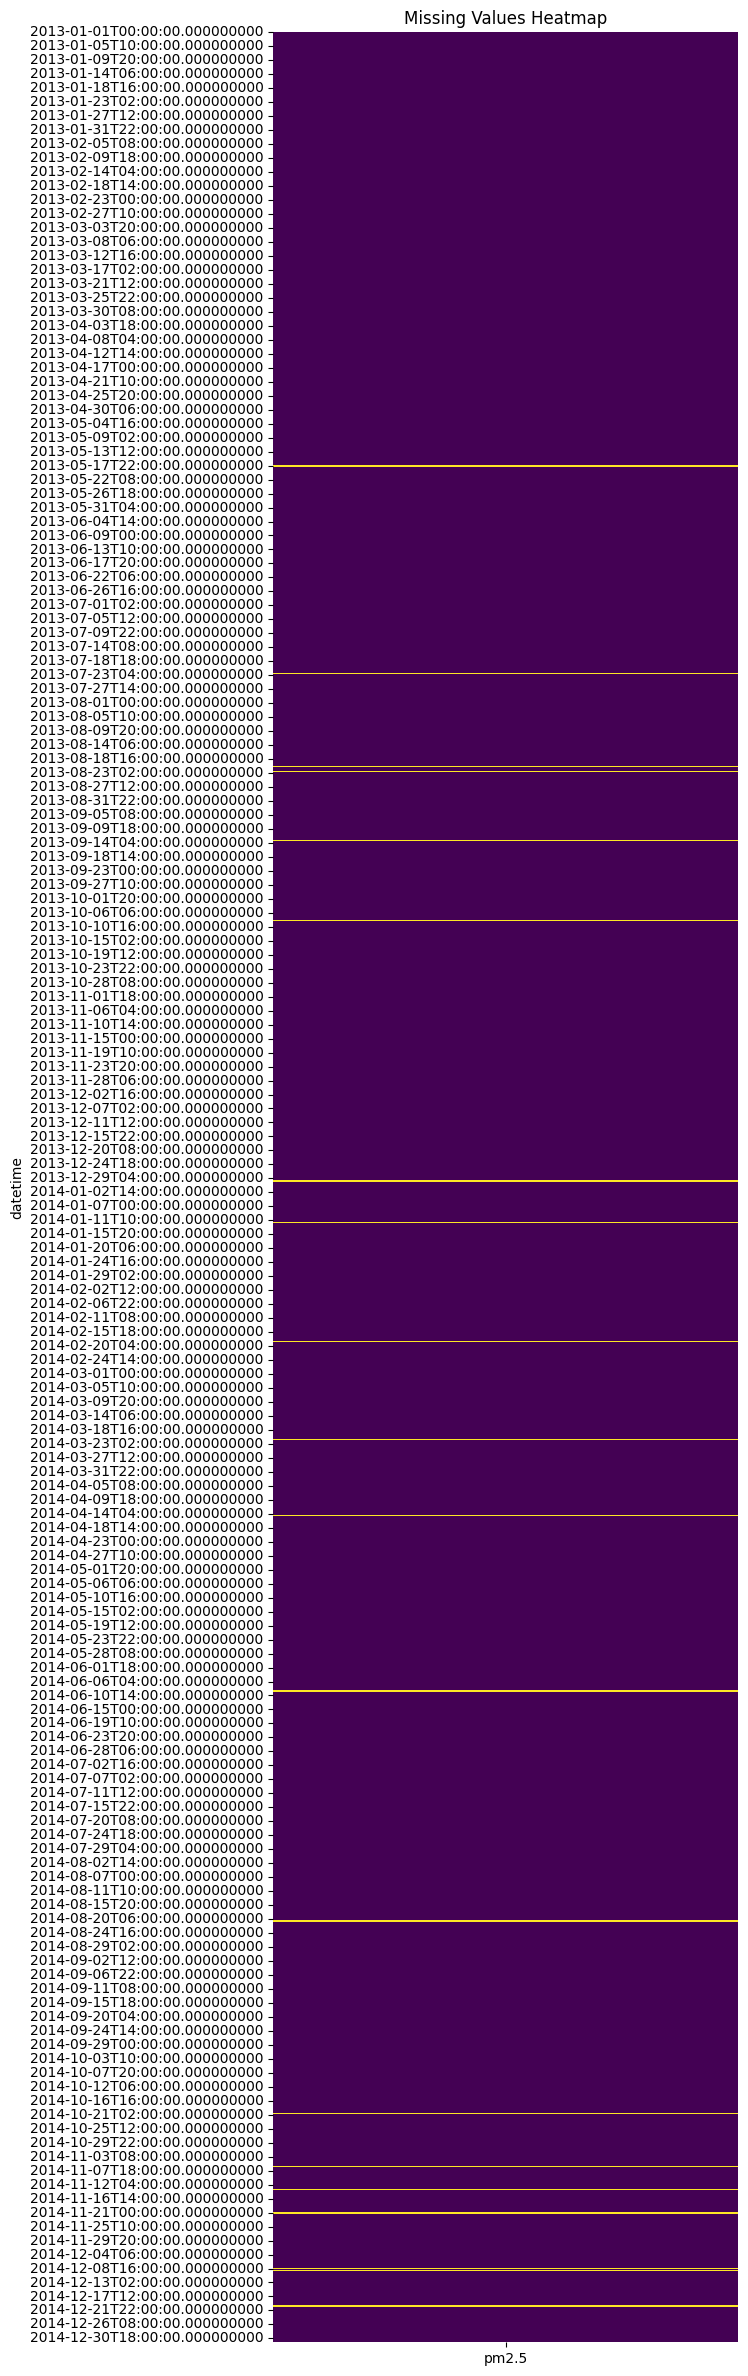

In [7]:
# visualize the missing values again
plt.figure(figsize=(6,30))
sns.heatmap(df['pm2.5'].isnull().to_frame(), cbar=False, cmap='viridis')  # Convert Series to DataFrame
plt.title('Missing Values Heatmap')
plt.show()

In [8]:
# Dealing with missing values
df['pm2.5'].interpolate(method='linear', inplace=True)

In [9]:
df.isnull().sum()

,0
pm2.5,0
DEWP,0
TEMP,0
PRES,0
cbwd,0
Iws,0
Is,0
Ir,0


In [10]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['cbwd'], drop_first=True)

In [11]:
df[['cbwd_NW', 'cbwd_SE', 'cbwd_cv']] = df[['cbwd_NW', 'cbwd_SE', 'cbwd_cv']].astype(int)

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pm2.5,17520.0,99.800000,95.929345,2.00,30.00,72.00,135.00,886.00
DEWP,17520.0,1.690925,14.274325,-40.00,-10.00,2.00,15.00,26.00
TEMP,17520.0,13.039384,11.857635,-17.00,3.00,14.00,23.00,42.00
PRES,17520.0,1016.218579,10.154897,991.00,1008.00,1016.00,1025.00,1046.00
Iws,17520.0,20.337931,45.887481,0.45,1.79,4.92,18.32,490.38
Is,17520.0,0.034418,0.594332,0.00,0.00,0.00,0.00,23.00
Ir,17520.0,0.148288,1.108909,0.00,0.00,0.00,0.00,25.00
cbwd_NW,17520.0,0.295034,0.456071,0.00,0.00,0.00,1.00,1.00
cbwd_SE,17520.0,0.358847,0.479676,0.00,0.00,0.00,1.00,1.00
cbwd_cv,17520.0,0.228653,0.419977,0.00,0.00,0.00,0.00,1.00


In [13]:
cols_to_convert = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

df[cols_to_convert] = df[cols_to_convert].astype('float32')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2013-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pm2.5    17520 non-null  float32
 1   DEWP     17520 non-null  float32
 2   TEMP     17520 non-null  float32
 3   PRES     17520 non-null  float32
 4   Iws      17520 non-null  float32
 5   Is       17520 non-null  float32
 6   Ir       17520 non-null  float32
 7   cbwd_NW  17520 non-null  int64  
 8   cbwd_SE  17520 non-null  int64  
 9   cbwd_cv  17520 non-null  int64  
dtypes: float32(7), int64(3)
memory usage: 1.0 MB


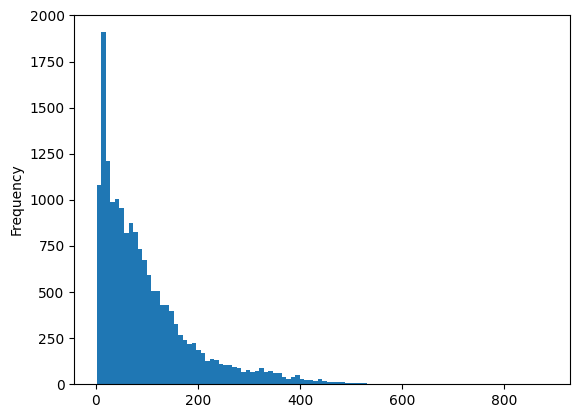

In [15]:
df['pm2.5'].plot(kind='hist', bins=100)
plt.show()

Since the PM2.5 is right-skewed, we apply a log transformation to stabilize the variance and make the distribution more normal.

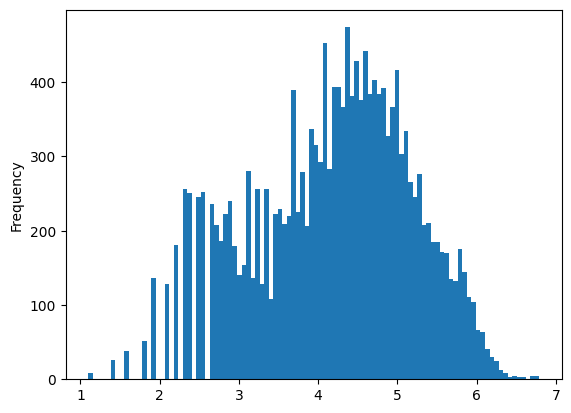

In [16]:
df['pm2.5_log'] = np.log1p(df['pm2.5'])
df['pm2.5_log'].plot(kind='hist', bins=100)
plt.show()

In [17]:
dl = df['pm2.5_log'].copy()
train = dl.iloc[:-24*60]
test = dl.iloc[-24*60:]

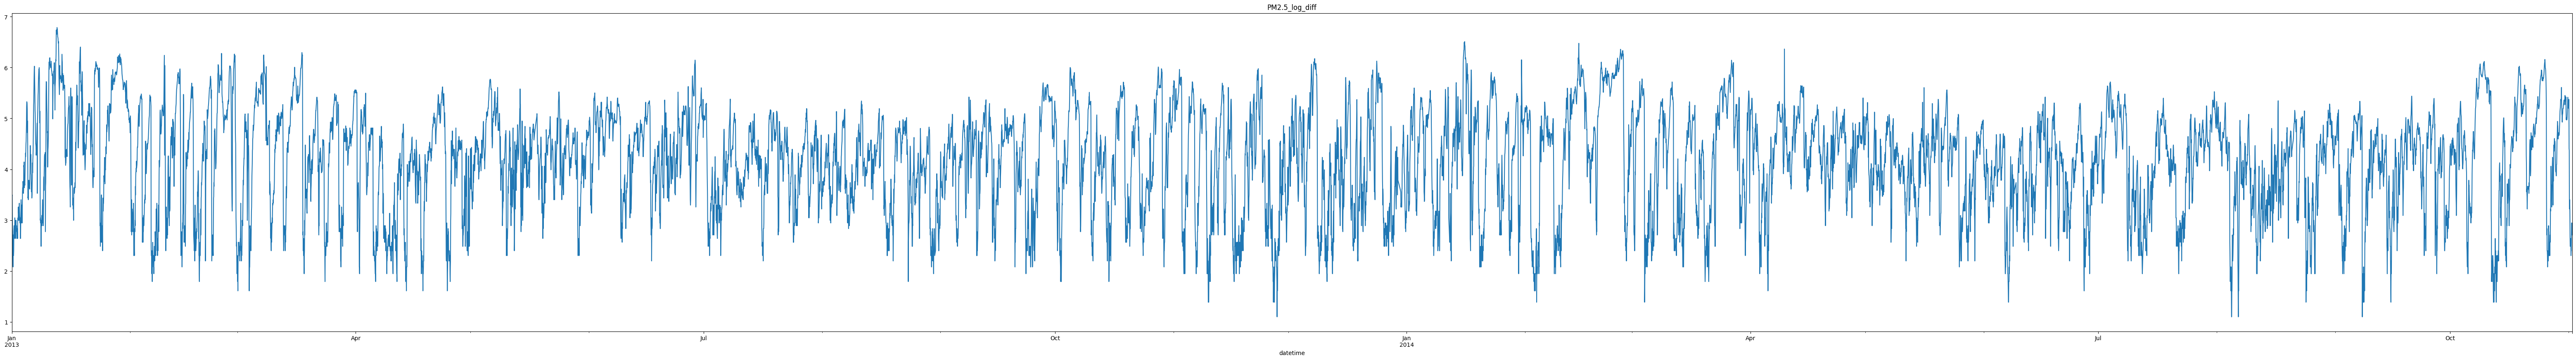

In [18]:
# Visualize the target
fig, ax = plt.subplots(figsize=(80, 10))
train.plot(ax=ax)
ax.set_title('PM2.5_log_diff')
plt.show()

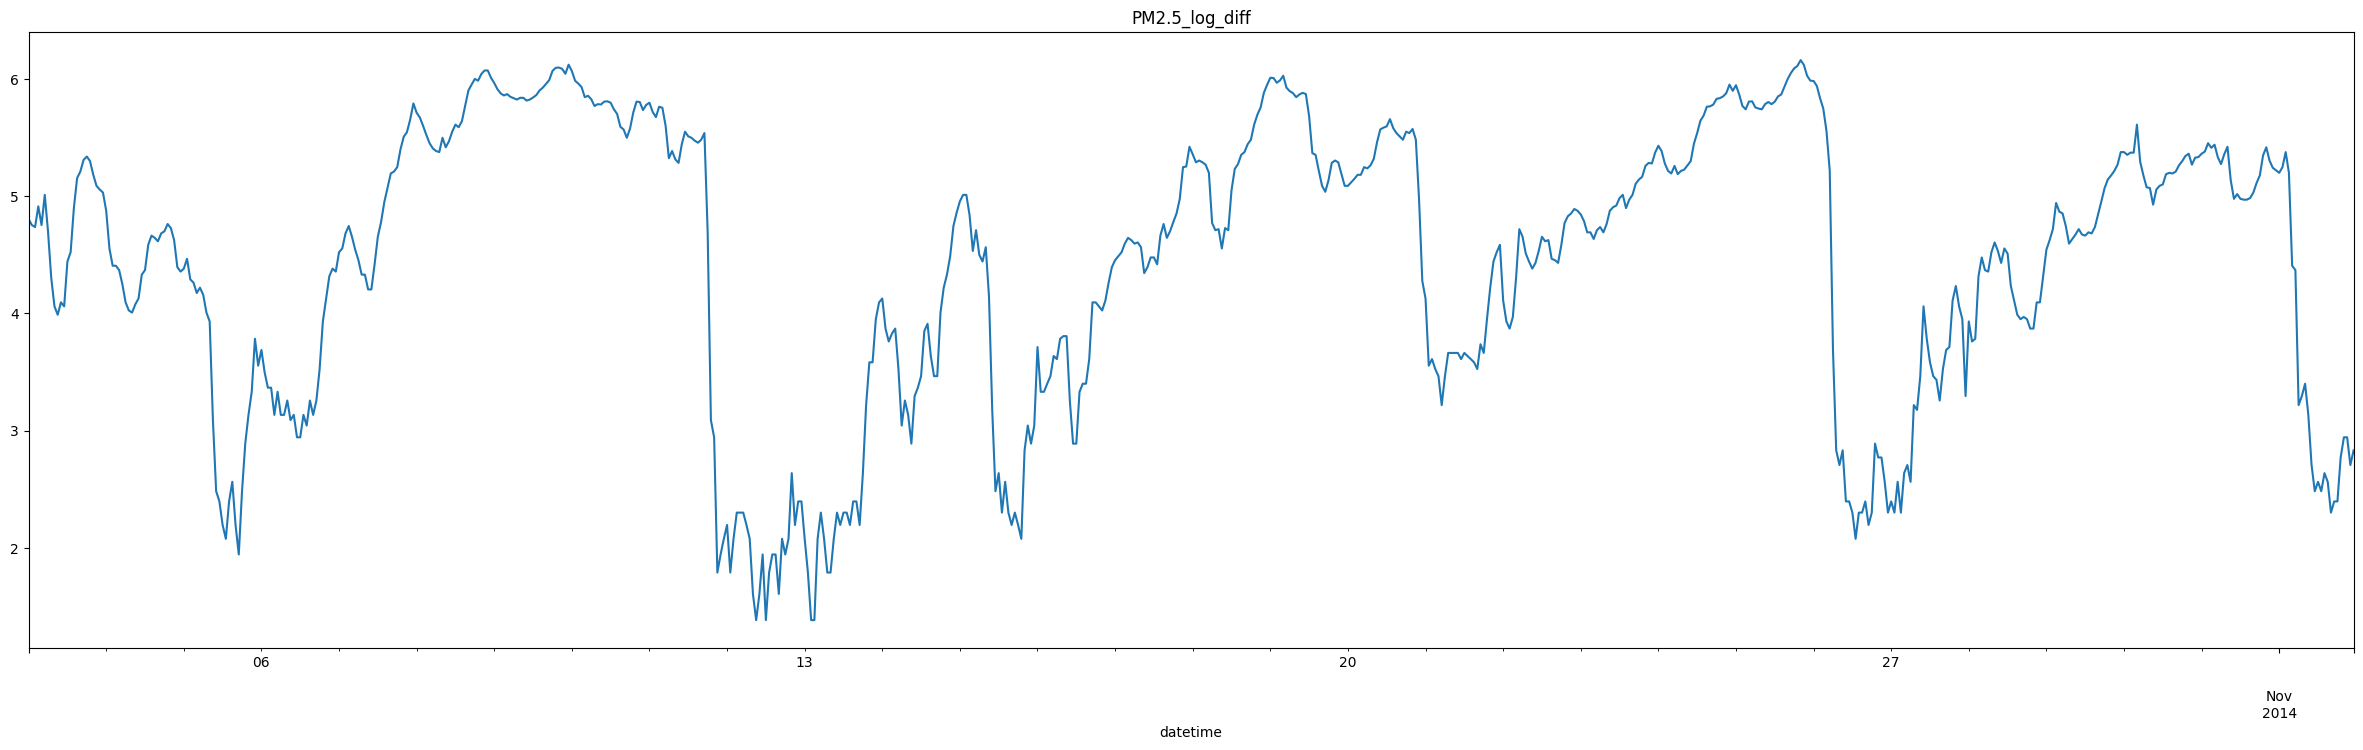

In [19]:
# Zoom in
fig, ax = plt.subplots(figsize=(30, 8))
train[-24*30:].plot(ax=ax)
ax.set_title('PM2.5_log_diff')
plt.show()

## Model Selection

In [39]:
# Check stability
from statsmodels.tsa.stattools import adfuller
result1 = adfuller(train)
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])

ADF Statistic: -16.476968
p-value: 0.000000


The ADF test above shows that it is a stationary series

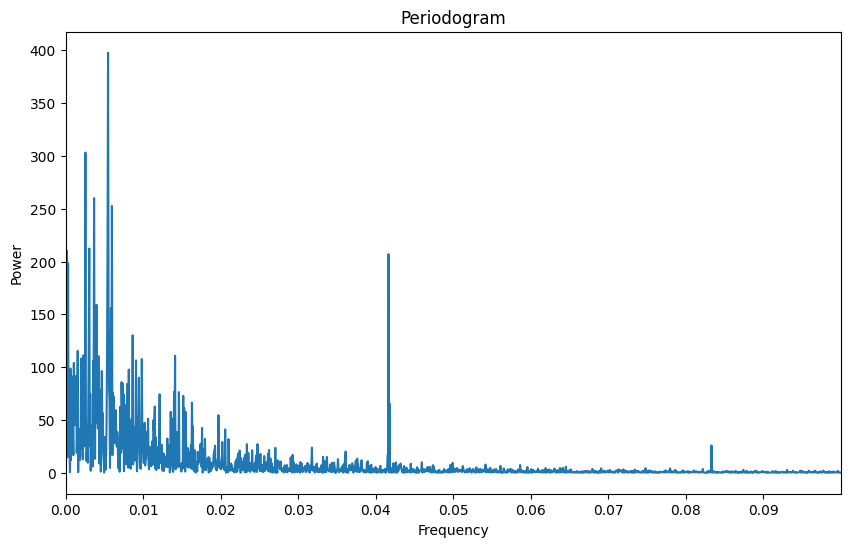

In [40]:
# Identify the seasonality

from scipy.signal import periodogram, find_peaks

# Calculate the periodogram
frequencies, power = periodogram(train)

# Plot the periodogram
plt.figure(figsize=(10,6))
plt.plot(frequencies, power)
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')

plt.xticks(np.arange(0, 0.1, step=0.01))
plt.xlim(0, 0.1)
plt.show()


0.042 corresponds to the short period 1/0.042 ~ 24 h.

### Manually Order Selection

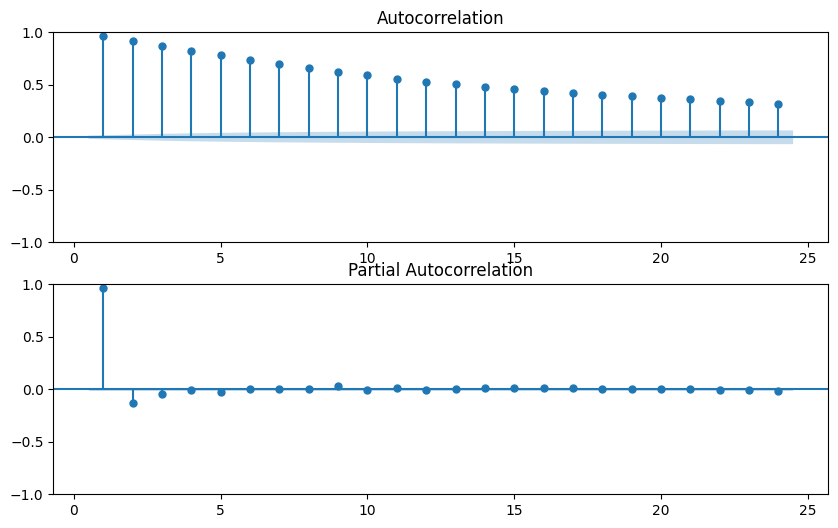

In [41]:
# Plot ACF and PACF

fig, axs = plt.subplots(2,1, figsize=(10, 6))
plot_acf(train, ax=axs[0], zero=False, lags=24)
plot_pacf(train, ax=axs[1], zero=False, lags=24)
plt.show()

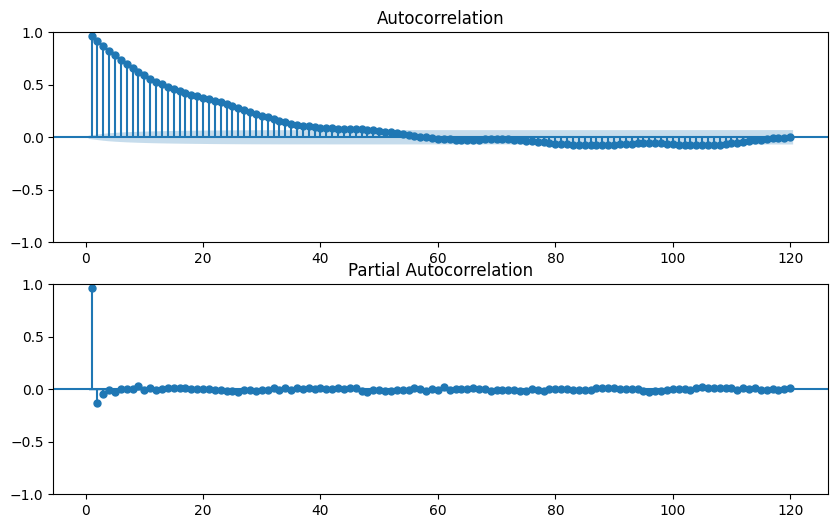

In [42]:
# Plot ACF and PACF

fig, axs = plt.subplots(2,1, figsize=(10, 6))
plot_acf(train, ax=axs[0], zero=False, lags=24*5)
plot_pacf(train, ax=axs[1], zero=False, lags=24*5)
plt.show()

p=1, q=0

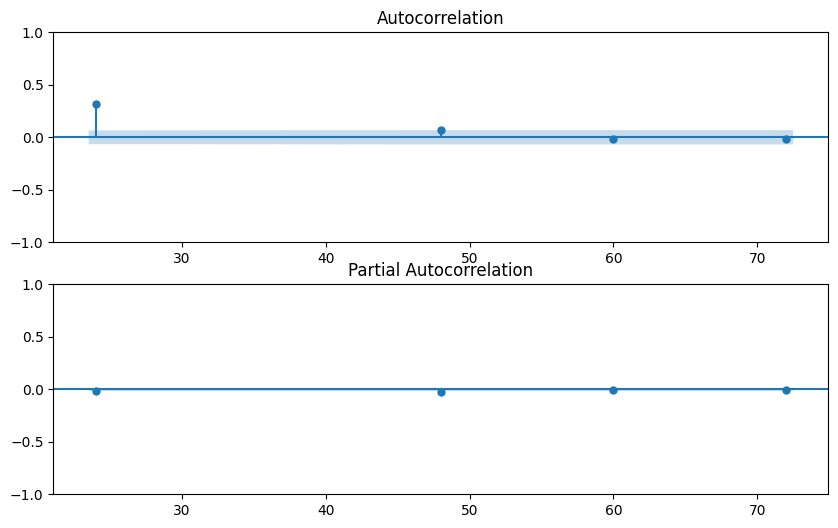

In [43]:
lags=[24, 48, 60, 72]
fig, axs = plt.subplots(2,1, figsize=(10, 6))
plot_acf(train, ax=axs[0], zero=False, lags=lags)
plot_pacf(train, ax=axs[1], zero=False, lags=lags)
plt.show()

P=0, Q=1

In [44]:
# Order (1,0,0) (0,1,1, 24)

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(0, 1, 1, 24))
results_1 = model.fit()

# Print the summary of the model
print(results_1.summary())


                                      SARIMAX Results                                       
Dep. Variable:                            pm2.5_log   No. Observations:                16080
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 24)   Log Likelihood               -1416.915
Date:                              Fri, 20 Sep 2024   AIC                           2839.830
Time:                                      20:17:55   BIC                           2862.882
Sample:                                  01-01-2013   HQIC                          2847.453
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9637      0.002    458.068      0.000       0.960       0.968
ma.S.L24      -0.99

In [21]:
# Order (1,0,0)

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train, order=(1, 0, 0))
results_3 = model.fit()
# Print the summary of the model
print(results_3.summary())

                               SARIMAX Results                                
Dep. Variable:              pm2.5_log   No. Observations:                16080
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1655.854
Date:                Fri, 20 Sep 2024   AIC                           3315.708
Time:                        20:30:29   BIC                           3331.078
Sample:                    01-01-2013   HQIC                          3320.790
                         - 11-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9980      0.001   1752.131      0.000       0.997       0.999
sigma2         0.0719      0.000    228.887      0.000       0.071       0.073
Ljung-Box (L1) (Q):                 189.93   Jarque-

In [22]:
# Order (2,0,0)

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train, order=(2, 0, 0))
results_4 = model.fit()
# Print the summary of the model
print(results_4.summary())

                               SARIMAX Results                                
Dep. Variable:              pm2.5_log   No. Observations:                16080
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1558.474
Date:                Fri, 20 Sep 2024   AIC                           3122.947
Time:                        20:30:40   BIC                           3146.003
Sample:                    01-01-2013   HQIC                          3130.571
                         - 11-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1076      0.005    240.382      0.000       1.099       1.117
ar.L2         -0.1097      0.004    -24.399      0.000      -0.119      -0.101
sigma2         0.0710      0.000    229.989      0.0

In [24]:
# Order (2,0,0) (0,1,1, 24)

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train, order=(2, 0, 0), seasonal_order=(0, 1, 1, 24))
results_2 = model.fit()

# Print the summary of the model
print(results_2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            pm2.5_log   No. Observations:                16080
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood               -1315.369
Date:                              Fri, 20 Sep 2024   AIC                           2638.739
Time:                                      20:33:17   BIC                           2669.474
Sample:                                  01-01-2013   HQIC                          2648.902
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0720      0.005    230.265      0.000       1.063       1.081
ar.L2         -0.11

In [28]:
# Order (1,1,0)

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train, order=(1, 1, 0))
results_5 = model.fit()

# Print the summary of the model
print(results_5.summary())

                               SARIMAX Results                                
Dep. Variable:              pm2.5_log   No. Observations:                16080
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1565.549
Date:                Fri, 20 Sep 2024   AIC                           3135.097
Time:                        20:38:49   BIC                           3150.468
Sample:                    01-01-2013   HQIC                          3140.179
                         - 11-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1087      0.004     24.391      0.000       0.100       0.117
sigma2         0.0711      0.000    246.490      0.000       0.071       0.072
Ljung-Box (L1) (Q):                   0.05   Jarque-

In [32]:
# Order (2,1,0)

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train, order=(2, 1, 0))
results_6 = model.fit()

# Print the summary of the model
print(results_6.summary())

                               SARIMAX Results                                
Dep. Variable:              pm2.5_log   No. Observations:                16080
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1563.265
Date:                Fri, 20 Sep 2024   AIC                           3132.529
Time:                        20:39:34   BIC                           3155.585
Sample:                    01-01-2013   HQIC                          3140.153
                         - 11-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1068      0.004     23.913      0.000       0.098       0.116
ar.L2          0.0169      0.006      2.856      0.004       0.005       0.028
sigma2         0.0711      0.000    246.413      0.0

In [34]:
# Order (2,1,0) (0,1,1, 24)

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train, order=(2, 1, 0), seasonal_order=(0, 1, 1, 24))
results_7 = model.fit()

# Print the summary of the model
print(results_7.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            pm2.5_log   No. Observations:                16080
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 24)   Log Likelihood               -1494.446
Date:                              Fri, 20 Sep 2024   AIC                           2996.891
Time:                                      20:42:51   BIC                           3027.626
Sample:                                  01-01-2013   HQIC                          3007.055
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0913      0.005     20.174      0.000       0.082       0.100
ar.L2          0.00

In [20]:
# Order (1,1,0) (0,1,1, 24)

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train, order=(1, 1, 0), seasonal_order=(0, 1, 1, 24))
results_8 = model.fit()

# Print the summary of the model
print(results_8.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            pm2.5_log   No. Observations:                16080
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 24)   Log Likelihood               -1494.996
Date:                              Fri, 20 Sep 2024   AIC                           2995.993
Time:                                      20:48:56   BIC                           3019.044
Sample:                                  01-01-2013   HQIC                          3003.615
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0921      0.005     20.367      0.000       0.083       0.101
ma.S.L24      -0.99

The best order is (2,0,0) (0,1,1, 24)

In [21]:
# Order (2,0,0) (0,1,1, 24)

# Fit the SARIMAX model with exogenous variables
model = SARIMAX(train, order=(2, 0, 0), seasonal_order=(0, 1, 1, 24))
results = model.fit()

# Print the summary of the model
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            pm2.5_log   No. Observations:                16080
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood               -1315.369
Date:                              Fri, 20 Sep 2024   AIC                           2638.739
Time:                                      20:51:45   BIC                           2669.474
Sample:                                  01-01-2013   HQIC                          2648.902
                                       - 11-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0720      0.005    230.265      0.000       1.063       1.081
ar.L2         -0.11

## Prediction and Evaluation

In [24]:
# Generate predictions on the known dataset for evaluation
dynamic_prediction = results.get_prediction(start=-12, dynamic=True)

# Extract prediction mean
mean_prediction = dynamic_prediction.predicted_mean

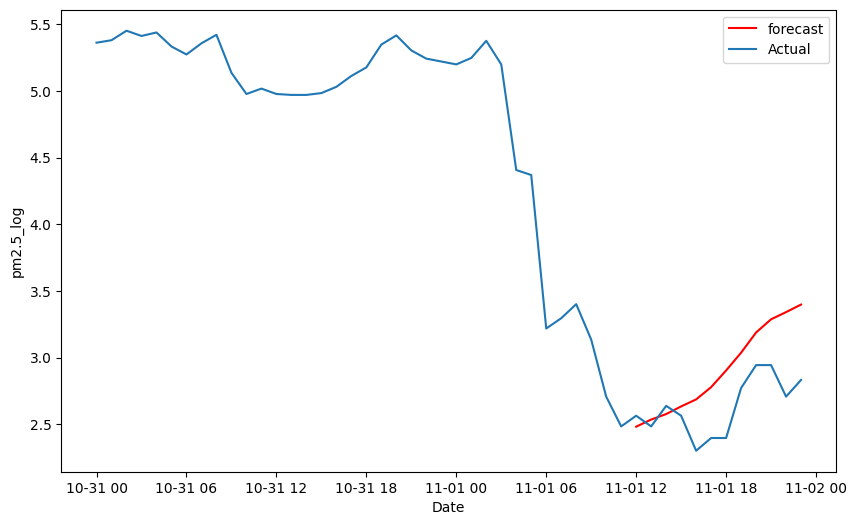

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
# plot your mean forecast
plt.plot(mean_prediction, color='r', label='forecast')

plt.plot(train[-48:], label='Actual')


# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('pm2.5_log')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Generate predictions
forecast = results.get_prediction(start=-100).predicted_mean
# Evaluation
mae = mean_absolute_error(forecast,train[-100:])
mse = mean_squared_error(forecast, train[-100:])
print(mae)
print(mse)

0.20340458219301039
0.0724994363517206


Now, let's include exogenous variables

In [ ]:
# Fit the SARIMAX model with exogenous variables

# Define the exogenous variables
exogs = train[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']]
exogs[['cbwd_NW', 'cbwd_SE', 'cbwd_cv']] = exogs[['cbwd_NW', 'cbwd_SE', 'cbwd_cv']].astype(int)
model = SARIMAX(train['pm2.5_log'], order=(1, 1, 0), exog=exogs)
results = model.fit()

# Print the summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              pm2.5_log   No. Observations:                14520
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1296.904
Date:                Mon, 19 Aug 2024   AIC                           2615.807
Time:                        21:19:47   BIC                           2699.223
Sample:                    01-01-2013   HQIC                          2643.528
                         - 08-28-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DEWP           0.0307      0.001     28.935      0.000       0.029       0.033
TEMP          -0.0046      0.001     -3.557      0.000      -0.007      -0.002
PRES          -0.0006      0.003     -0.217      0.8

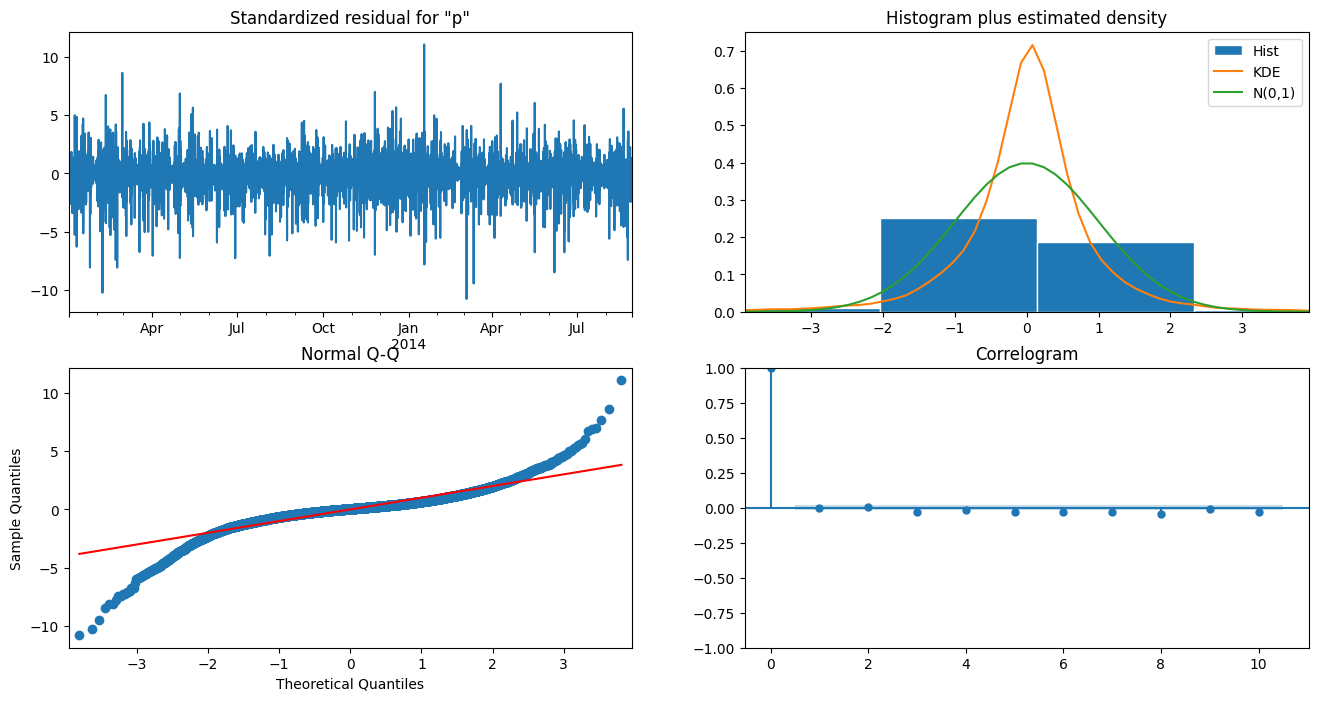

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Comparing with the first case without exogenous variables, it has a smaller AIC value, so the model shoudl be more reliable.

In [ ]:
# Generate predictions
forecast = results.get_prediction(start=-100).predicted_mean
# Evaluation
mae = mean_absolute_error(forecast,train['pm2.5_log'][-100:])
mse = mean_squared_error(forecast, train['pm2.5_log'][-100:])
print(mae)
print(mse)

0.20234598462939146
0.07074458794830314


Comparing with the first case, we get smaller mae and mse. So including exogenous variables indeed improve the model's performance.